# ortool处理

In [77]:
import numpy as np
import torch

from scipy.spatial import distance_matrix
from scipy.spatial.distance import cdist

#ortool 组件
from __future__ import print_function
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

import matplotlib.pyplot as plt

打印解决方案

In [78]:
def print_ortool_solution(manager, routing, solution):
    """Prints solution on console."""
    print("Objective: {}".format(solution.ObjectiveValue()))
    index = routing.Start(0)
    plan_output = "Route for vehicle 0:\n"
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += " {} ->".format(manager.IndexToNode(index))
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += " {}\n".format(manager.IndexToNode(index))
    print(plan_output)
    plan_output += "Route distance: {}miles\n".format(route_distance)

计算路径长度

输入

x 是一个形状为 (bsz, nb_nodes, 2) 的张量，表示一批TSP实例的城市坐标，其中bsz是批次大小（即有多少个独立的TSP实例），nb_nodes是每个TSP实例中的节点（城市）数量，最后的2代表每个节点的二维坐标。

tour 是一个形状为 (bsz, nb_nodes) 的张量，表示一批访问顺序（路径）。每个元素是一个整数，指示了访问城市（节点）的索引。

输出

L 是一个形状为(bsz,)的张量，表示批次和路径长度

In [79]:
def compute_tour_length(x, tour): 
    """
    Compute the length of a batch of tours
    Inputs : x of size (bsz, nb_nodes, 2) batch of tsp tour instances
             tour of size (bsz, nb_nodes) batch of sequences (node indices) of tsp tours
    Output : L of size (bsz,)             batch of lengths of each tsp tour
    """
    # x 是一个形状为 (bsz, nb_nodes, 2) 的张量，表示一批TSP实例的城市坐标，其中bsz是批次大小（即有多少个独立的TSP实例），nb_nodes是每个TSP实例中的节点（城市）数量，最后的2代表每个节点的二维坐标。
    # tour 是一个形状为 (bsz, nb_nodes) 的张量，表示一批访问顺序（路径）。每个元素是一个整数，指示了访问城市（节点）的索引。
    bsz = x.shape[0]
    nb_nodes = x.shape[1]#从输入张量x中获取批次大小和节点数量
    # 创建一个从0到bsz-1的整数张量，用于索引批次中的每一个TSP实例。device=x.device确保这个张量在与x相同的设备（CPU或GPU）上创建。
    # 相当于索引了每个批
    arange_vec = torch.arange(bsz, device=x.device)
    # 冒号 : 表示选择所有元素。在第一个维度（行），冒号意味着选取所有的行。
    # 数字 0 表示选择第二维度（列）中的第0个元素，即第一列。
    # 结合起来，tour[:,0] 的意思是从名为 tour 的二维张量中选择每一行的第一个元素
    first_cities = x[arange_vec, tour[:,0], :] # size(first_cities)=(bsz,2)获取第一个坐标
    previous_cities = first_cities # 存储第一个城市坐标作为上一个城市计算
    # 初始化一个全零张量L，其大小为bsz，用来累积每个路径的总长度
    L = torch.zeros(bsz, device=x.device)

    # 遍历tour里每个元素，作为current，计算与previous的距离，再将current的存储为previous
    with torch.no_grad():
        for i in range(1,nb_nodes):
            current_cities = x[arange_vec, tour[:,i], :] 
            L += torch.sum( (current_cities - previous_cities)**2 , dim=1 )**0.5 # dist(current, previous node) 
            previous_cities = current_cities
        L += torch.sum( (current_cities - first_cities)**2 , dim=1 )**0.5 # dist(last, first node)  
    return L 

获取求解的路径，并存储在tour中

In [80]:
# 定义一个名为get_routes的函数，它接收四个参数：
# manager: 路由索引管理器实例，帮助转换索引和节点。
# routing: 包含路由模型信息的对象。
# solution: 求解器找到的解决方案对象。
# nb_nodes: 每个TSP实例中最大节点数量，用于初始化输出张量的形状。
def get_routes(manager, routing, solution, nb_nodes):
    """Get vehicle routes from a solution and store them in a tensor of shape (bsz, nb_nodes)."""
    # 获取车辆数量
    bsz = routing.vehicles()
    
    # 初始化一个全零张量用于存储所有车辆的路径，假设路径长度为nb_nodes
    tour = torch.zeros((bsz, nb_nodes), dtype=torch.long)
    
    # 遍历每一个车辆
    for route_nbr in range(bsz):
        index = routing.Start(route_nbr)  # 起始位置索引
        node_index = 0  # 用于跟踪当前路径上的节点位置
        
        # 添加起始节点
        tour[route_nbr, node_index] = manager.IndexToNode(index)
        node_index += 1
        
        # 构建单个车辆的完整路径
        while not routing.IsEnd(index) and node_index < nb_nodes:
            index = solution.Value(routing.NextVar(index))
            tour[route_nbr, node_index] = manager.IndexToNode(index)
            node_index += 1
        
        # 如果路径较短，则剩余的位置保持为0（或可以用其他方式填充）
        if node_index < nb_nodes:
            tour[route_nbr, node_index:] = 0  # 或者根据需要填充特定值
    
    return tour

求解器优化部分

In [81]:
def optimize_routes(distance_matrix, depot, nb_nodes, print_solution_to_console=True):
    """Optimize routes and return them as a tensor of shape (bsz, nb_nodes)."""
    
    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(distance_matrix), 1, depot
    )  # num of vehicles set to 1
    
    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return distance_matrix[from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    if solution:
        # Call get_routes_as_tensor to return the result as a tensor.
        tour_tensor = get_routes(manager, routing, solution, nb_nodes)
        
        if print_solution_to_console:
            print_ortool_solution(manager, routing, solution)
        
        return tour_tensor
    else:
        print("No solution found.")
        return None


可视化

In [82]:
def plot_nodes(nodes, route=None, batch_idx=None, route_distance=None):
    """
    Plot nodes and optionally the route for a single batch.

    Parameters:
    - nodes: NumPy array of shape (num_nodes, 2) containing node coordinates.
    - route: List or array of node indices representing the route.
    - batch_idx: Index of the batch being plotted (for title).
    - route_distance: Total distance of the route (for display).
    """
    # Assign indices to nodes
    indices = np.arange(len(nodes))

    # Plot the nodes
    plt.figure(figsize=(8, 6))
    plt.scatter(nodes[:, 0], nodes[:, 1], color="blue", s=100, edgecolors="black")

    # Annotate each node with its index
    for idx, (x, y) in zip(indices, nodes):
        plt.text(x + 0.1, y + 0.1, str(idx), fontsize=12, color="red")

    # If a route is provided, plot the route
    if route is not None:
        # Ensure the route is a complete loop by appending the start node at the end
        complete_route = np.append(route, route[0])
        # Get the coordinates of the nodes in the order of the route
        route_nodes = nodes[complete_route]
        # Plot the route
        plt.plot(route_nodes[:, 0], route_nodes[:, 1], "r-", linewidth=2, label="Route")
        # Mark the start and end points
        plt.scatter(
            nodes[route[0], 0],
            nodes[route[0], 1],
            color="green",
            s=150,
            label="Start/End",
        )
        plt.legend()

    # Add labels and title
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    if batch_idx is not None:
        title = f"Batch {batch_idx}: Nodes for Traveling Salesman Problem"
        if route_distance is not None:
            title += f" | Total Distance: {route_distance:.2f}"
        plt.title(title)
    else:
        plt.title("Nodes for Traveling Salesman Problem")
    plt.grid(True)
    plt.show()

In [83]:
def plot_all_batches(nodes_tensor, routes_list, x, tour):
    """
    Plot nodes and routes for all batches, including the total route distance from compute_tour_length.

    Parameters:
    - nodes_tensor: Tensor of shape (bsz, num_nodes, 2) containing node coordinates for each batch.
    - routes_list: List of route tensors for each batch.
    - x: Tensor of shape (bsz, nb_nodes, 2) containing node coordinates for each batch.
    - tour: Tensor of shape (bsz, nb_nodes) containing sequences (node indices) of tsp tours for each batch.
    """
    bsz = nodes_tensor.shape[0]

    # Calculate distances using compute_tour_length
    L = compute_tour_length(x, tour)

    for batch_idx in range(bsz):
        nodes = nodes_tensor[batch_idx].numpy()  # Convert tensor to NumPy array
        route = routes_list[batch_idx] if routes_list[batch_idx] is not None else None
        
        # Get route distance from L
        route_distance = L[batch_idx].item() if L is not None and len(L) > batch_idx else None
        
        # Call plot_nodes for this batch with the route distance
        plot_nodes(nodes, route=route, batch_idx=batch_idx, route_distance=route_distance)

参数设定，可同时处理多个batch

Optimized routes for batch 0:
tensor([[ 0, 19, 45, 20, 49, 41, 24, 36,  2, 43, 14, 33,  8,  9, 11, 31, 21, 28,
         27, 17, 48, 37,  6, 18, 46,  5, 22,  7,  4, 47, 30, 12, 29, 23, 35, 38,
         42, 10, 39,  3, 16, 26, 32, 15, 25,  1, 13, 34, 40, 44]])
Optimized routes for batch 1:
tensor([[ 0,  1, 10, 12, 26, 49, 11, 37, 28,  3, 14, 30, 42, 15, 32, 35,  8,  2,
         44, 20,  7, 18, 16, 45, 40,  9, 29, 25,  6, 48, 38, 17, 22, 21, 33, 27,
          4, 19, 47, 23, 41, 31, 13, 43, 24, 39, 36, 46,  5, 34]])
Optimized routes for batch 2:
tensor([[ 0, 17, 16, 34,  5, 28,  9,  4, 44, 32, 19, 14, 25, 45, 22, 37, 40, 39,
         36, 41, 20,  6, 23, 11, 15, 21, 13, 47,  1, 10,  3, 46, 26, 33, 35, 43,
         29, 12,  7, 31, 24,  2, 27, 30,  8, 42, 38, 49, 48, 18]])
Optimized routes for batch 3:
tensor([[ 0, 29,  8, 24,  9, 44, 49, 18,  5, 19, 37, 34, 22, 39, 31, 27, 28, 47,
         41, 35, 16, 32, 13, 43, 14, 36, 33, 30, 20, 40,  7, 45, 11, 15, 17,  6,
         42, 48, 23, 46, 21,  2

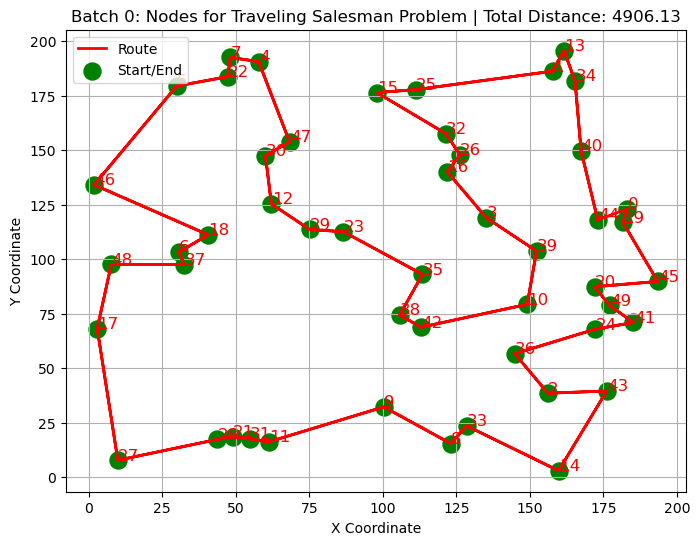

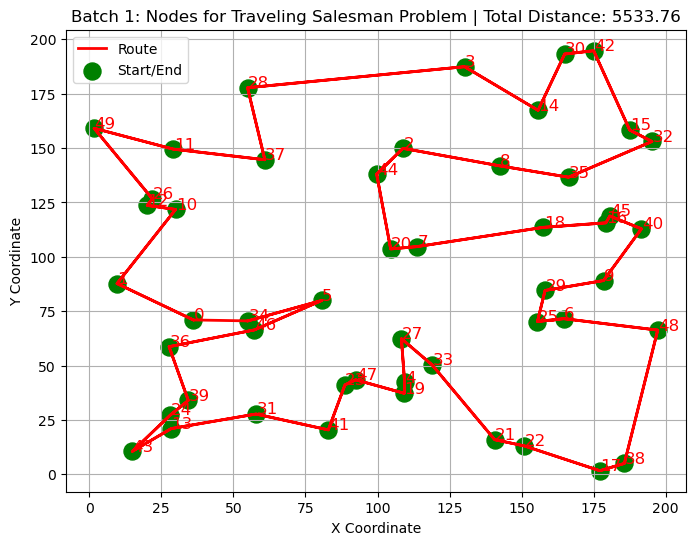

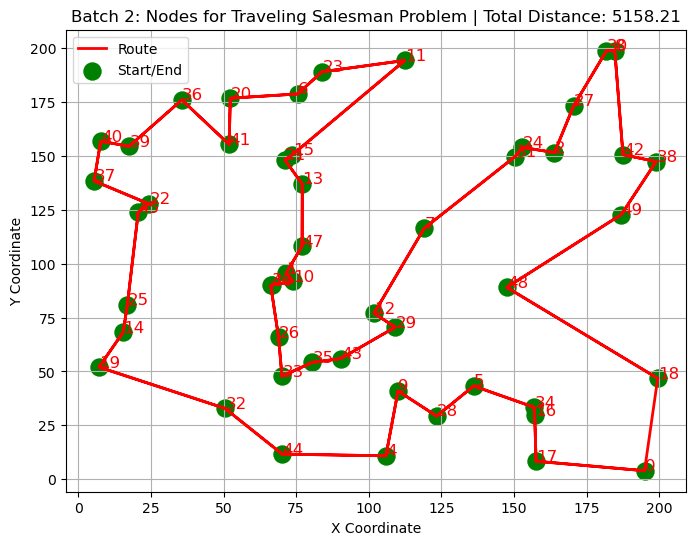

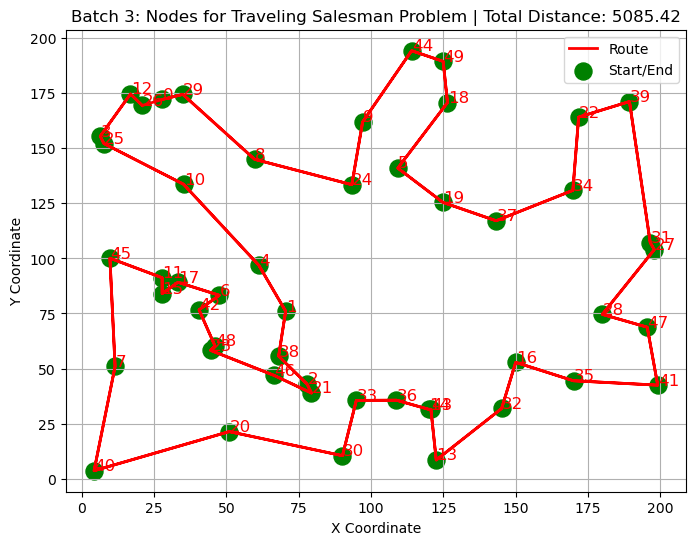

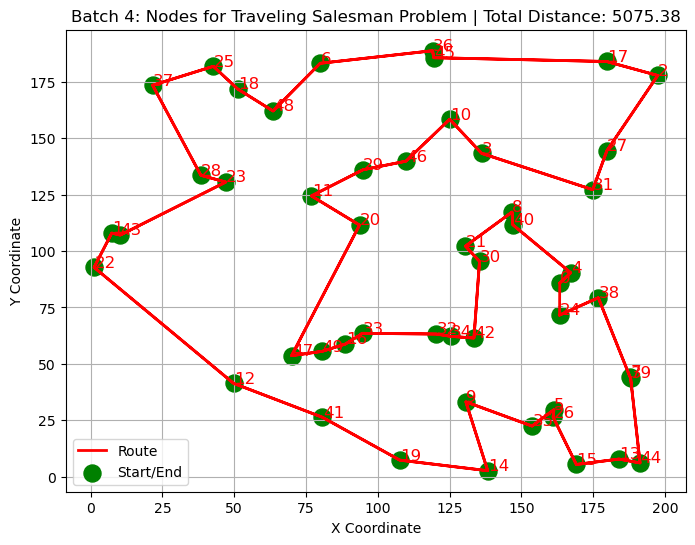

In [84]:
# 定义批次大小和其他参数
bsz = 5  # 假设你想要生成5个批次

num_nodes = 50  # 每个批次中节点的数量
# num_nodes = 10  # 每个批次中节点的数量

coord_range = (1, 200)  # 节点坐标的范围
# coord_range = (1, 5)  # 节点坐标的范围

# 生成bsz个批次的节点坐标
nodes_tensor = torch.rand(bsz, num_nodes, 2) * (coord_range[1] - coord_range[0]) + coord_range[0]
# 假设optimize_routes函数返回的路径已经存储在routes_list中，并转换为适合compute_tour_length的格式
# 这里用随机生成的数据作为示例
routes_list = [np.random.permutation(num_nodes) for _ in range(bsz)]
tour_tensor = torch.tensor(routes_list)

# 确保tour_tensor是整形张量
tour_tensor = tour_tensor.to(torch.long)

# 现在你可以调用compute_tour_length来计算每条路径的总距离
L = compute_tour_length(nodes_tensor, tour_tensor)


# 设置初始节点（对于所有批次都是第一个节点）
depot = 0  # 初始节点索引

# 准备一个列表来保存每个批次的距离矩阵
distance_matrices = []
routes_list = []

for batch_idx in range(bsz):
    # 将当前批次的节点坐标转换为NumPy数组
    nodes = nodes_tensor[batch_idx].numpy()
    
    # 计算当前批次的距离矩阵
    distances = np.round(1000 * cdist(nodes, nodes, metric='euclidean')).astype(int)
    
    # 添加到距离矩阵列表中
    distance_matrices.append(distances)

# 现在有一个列表，其中包含bsz个距离矩阵，每个对应一个批次

# 对于每个批次，调用optimize_routes函数
for batch_idx in range(bsz):
    # 注意：这里假设optimize_routes已经根据之前的讨论进行了修改，可以接受nb_nodes和print_solution_to_console参数
    routes = optimize_routes(distance_matrices[batch_idx], depot, nb_nodes=num_nodes, print_solution_to_console=False)
    
    if routes is not None:
        print(f"Optimized routes for batch {batch_idx}:")
        print(routes)
        routes_list.append(routes)
    else:
        print(f"No solution found for batch {batch_idx}.")

plot_all_batches(nodes_tensor, routes_list, nodes_tensor, tour_tensor)